Основная задача аналитиков в нашей компании - растить бизнес. Иногда мы сами не знаем где прячутся эти точки кратного роста, поэтому порой приходится кранчить данные и искать зависимости/аномалии, генерировать гипотезы в процессе и потом предлагать проекты. Мы дадим доступ к базе со срезом транзакций. Твое задание: найти все интересные на твой взгляд инсайты и представь их в любом удобном виде (ноутбук желательно приложить). 


In [ ]:
# Подключаем необходимые библиотеки

In [183]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sa
from datetime import date, datetime, timedelta
import psycopg2 as pg
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly_express as px
import folium
import geopandas as gpd
from operator import attrgetter
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams["axes.labelsize"] = 18

%matplotlib inline

HOST = "rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net"
PORT = "6432"
USER = "analytics"
PW = "HRanalytics"
DB = "hr-analytics"

PATH = 'd:\\sbermarket\\analytics\\'

In [51]:
# Снижаем использование памяти
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type == 'datetime64[ns]':
#             pass
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df

In [ ]:
# Подключаемся БД

In [52]:
connection = pg.connect(host=HOST,
                        port=PORT,
                        dbname=DB,
                        sslmode='require',
                        user=USER,
                        password=PW)

In [4]:
orders = pd.io.sql.read_sql('SELECT * FROM orders;', connection)
delivery_windows = pd.io.sql.read_sql('SELECT * FROM delivery_windows;', connection)
stores = pd.io.sql.read_sql('SELECT * FROM stores;', connection)
addresses = pd.io.sql.read_sql('SELECT * FROM addresses;', connection)
replacements = pd.io.sql.read_sql('SELECT * FROM replacements;', connection)
cancellations = pd.io.sql.read_sql('SELECT * FROM cancellations;', connection)

In [5]:
# Сохраняем данные в csv
orders.to_csv('orders.csv', index=False)
delivery_windows.to_csv('delivery_windows.csv', index=False)
stores.to_csv('stores.csv', index=False)
addresses.to_csv('addresses.csv', index=False)
replacements.to_csv('replacements.csv', index=False)
cancellations.to_csv('cancellations.csv', index=False)

In [184]:
# Читаем сохраненные csv
orders = pd.read_csv(PATH + 'orders.csv', parse_dates=['shipped_at', 'created_at'])
delivery_windows = pd.read_csv(PATH + 'delivery_windows.csv', parse_dates=['starts_at', 'ends_at'])
stores = pd.read_csv(PATH + 'stores.csv')
addresses = pd.read_csv(PATH + 'addresses.csv')
replacements = pd.read_csv(PATH + 'replacements.csv')
cancellations = pd.read_csv(PATH + 'cancellations.csv')

In [8]:
# Предварительный анализ данных

In [55]:
# orders = reduce_mem_usage(orders)

Mem. usage decreased to 41.22 Mb (46.4% reduction)


In [185]:
orders.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,2018-08-26 02:06:55,888330,1,226459
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,2018-08-26 05:43:20,888394,1,226460
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,2018-08-26 06:12:13,888420,1,226459
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,2018-08-26 06:13:59,888422,1,226462
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,2018-08-26 07:40:58,870688,1,226458


In [186]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720433 entries, 0 to 720432
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  720433 non-null  int64         
 1   user_id             720433 non-null  int64         
 2   total_cost          720433 non-null  float64       
 3   cost                720433 non-null  float64       
 4   item_total          720433 non-null  int64         
 5   promo_total         720433 non-null  float64       
 6   total_weight        720433 non-null  int64         
 7   total_quantity      720433 non-null  int64         
 8   state               720433 non-null  object        
 9   shipped_at          720433 non-null  datetime64[ns]
 10  created_at          720433 non-null  datetime64[ns]
 11  ship_address_id     720433 non-null  int64         
 12  store_id            720433 non-null  int64         
 13  delivery_window_id  720433 no

In [187]:
orders['created_at'].describe()

count                  720433
unique                 703953
top       2019-12-17 17:32:04
freq                        4
first     2018-08-26 00:05:41
last      2019-12-18 18:02:41
Name: created_at, dtype: object

In [188]:
orders['state'].value_counts(normalize=True)

shipped     0.999960
canceled    0.000021
pending     0.000017
ready       0.000001
shipping    0.000001
Name: state, dtype: float64

In [189]:
# Отмененных заказов меньше 1%

In [190]:
# Создаем дополнительные признаки для анализа

In [191]:
orders['created_at_month'] = orders['created_at'].dt.strftime("%Y-%m") 
orders['created_at_dayofweek'] = orders['created_at'].dt.dayofweek
orders['created_at_year'] = orders['created_at'].dt.year
orders['created_at_time'] = orders['created_at'].dt.hour

orders['shipped_at_month'] = orders['shipped_at'].dt.strftime("%Y-%m") 
orders['shipped_at_dayofweek'] = orders['shipped_at'].dt.dayofweek
orders['shipped_at_year'] = orders['shipped_at'].dt.year

## Заполняем названия региона

In [15]:
### Для того, чтобы выполнять анализ в разрезе регионов, необходимо по координатам определить регион. Воспользуемся библиотекой geopandas

In [192]:
polygons = gpd.read_file(PATH + 'russia_geojson_wgs84.geojson', index=['id'])
polygons = polygons[['id', 'name', 'geometry']]

In [193]:
geo_addresses = gpd.GeoDataFrame(addresses, 
                                 geometry=gpd.points_from_xy(
                                     x=addresses['lon'], 
                                     y=addresses['lat'])
                                )

geo_addresses = gpd.sjoin(geo_addresses, 
                          polygons, 
                          how='left', 
                          op='within')

In [194]:
geo_addresses.head()

,lat,lon,id_left,elevator,floor,geometry,index_right,id_right,name
0,55.851604,37.634282,887760,NaN,13,POINT (37.63428 55.85160),82.0,78.0,Москва
1,55.855682,37.644165,888330,NaN,3,POINT (37.64416 55.85568),82.0,78.0,Москва
2,55.868020,37.671917,888379,NaN,-,POINT (37.67192 55.86802),82.0,78.0,Москва
3,55.858791,37.638656,888394,passenger,8,POINT (37.63866 55.85879),82.0,78.0,Москва
4,55.848593,37.592824,888416,NaN,-,POINT (37.59282 55.84859),82.0,78.0,Москва


In [195]:
geo_addresses = geo_addresses.rename(columns={'id_left': 'address_id', 'index_right':'region_id'})
geo_addresses = geo_addresses.drop(['elevator', 'floor', 'id_right'], axis=1)

In [196]:
# Проверяем есть ли пуcтые значения в колонках
geo_addresses.isna().sum()

lat           0
lon           0
address_id    0
geometry      0
region_id     1
name          1
dtype: int64

In [197]:
# Найдем строку с пустыми значениями
index_nan = geo_addresses['region_id'].index[geo_addresses['region_id'].apply(np.isnan)]
index_nan

Int64Index([6791], dtype='int64')

In [198]:
geo_addresses.loc[index_nan[0]]

lat                                       59.9833
lon                                       30.2273
address_id                                1124030
geometry      POINT (30.227311 59.98326579999999)
region_id                                     NaN
name                                          NaN
Name: 6791, dtype: object

In [199]:
geom = ('59.98326579999999, 30.227311')
locator = Nominatim(user_agent="myGeocoder", timeout=10).reverse(geom)

In [200]:
locator.raw['address']['state']

'Санкт-Петербург'

In [201]:
# Заполним пропуски полученными значеями
geo_addresses.loc[6791, 'region_id'] = 79
geo_addresses.loc[6791, 'name'] = 'Санкт-Петербург'

In [202]:
geo_addresses['region_id'] = geo_addresses['region_id'].astype('int16')

In [203]:
geo_addresses_for_merge = geo_addresses[['address_id', 'name']].drop_duplicates()

In [204]:
geo_addresses_for_merge

,address_id,name
0,887760,Москва
1,888330,Москва
2,888379,Москва
3,888394,Москва
4,888416,Москва
...,...,...
1492296,4126529,Омская область
1492297,7144663,Омская область
1492299,7145145,Омская область
1492300,7147129,Омская область


In [205]:
orders_w_regions = (pd.merge(orders, 
                            geo_addresses_for_merge,
                            how='left',
                            left_on='ship_address_id', 
                            right_on='address_id')
                    .drop('address_id', axis=1)
                   )

In [206]:
orders_w_regions.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,...,store_id,delivery_window_id,created_at_month,created_at_dayofweek,created_at_year,created_at_time,shipped_at_month,shipped_at_dayofweek,shipped_at_year,name
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,1,226459,2018-08,6,2018,2,2018-08,6,2018,Москва
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,...,1,226460,2018-08,6,2018,5,2018-08,6,2018,Москва
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,...,1,226459,2018-08,6,2018,6,2018-08,6,2018,Москва
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,...,1,226462,2018-08,6,2018,6,2018-08,6,2018,Москва
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,...,1,226458,2018-08,6,2018,7,2018-08,6,2018,Москва


In [207]:
orders_w_regions.shape

(720433, 22)

# Исследование данных

## Общий обзор

In [182]:
# orders_w_regions = reduce_mem_usage(orders_w_regions)

Mem. usage decreased to 68.02 Mb (46.2% reduction)


### Процент покупателей с повторными заказами

In [208]:
# Количесто заказов на покупателя
n_orders = orders_w_regions.groupby(['user_id'])['id'].nunique()

multi_orders_percent = np.sum(n_orders > 1) / orders_w_regions['user_id'].nunique()
print(f'Покупателей закзазывающих более 1 раза - {100 * multi_orders_percent:.2f}%')

Покупателей закзазывающих более 1 раза - 43.89%


### Процент покупателей использовавших промокод на покупку

In [209]:
orders_w_regions['promo_total'].value_counts(normalize=True)
# 86% процентов заказов осуществлялось без использования промокодов на покупку

 0.00       0.864196
-250.00     0.030744
-500.00     0.016945
-300.00     0.012680
-150.00     0.007818
              ...   
-14.91      0.000001
-2230.60    0.000001
-490.60     0.000001
-167.13     0.000001
-242.76     0.000001
Name: promo_total, Length: 19264, dtype: float64

Практически половина всех покупателей возвращаются за повторными покупками. Как мне кажется это важный параметр для роста бизнеса и имеет смысл увеличивать этот процент.

### Средний размер заказа

In [210]:
plt.rcParams['figure.figsize'] = (18, 8)

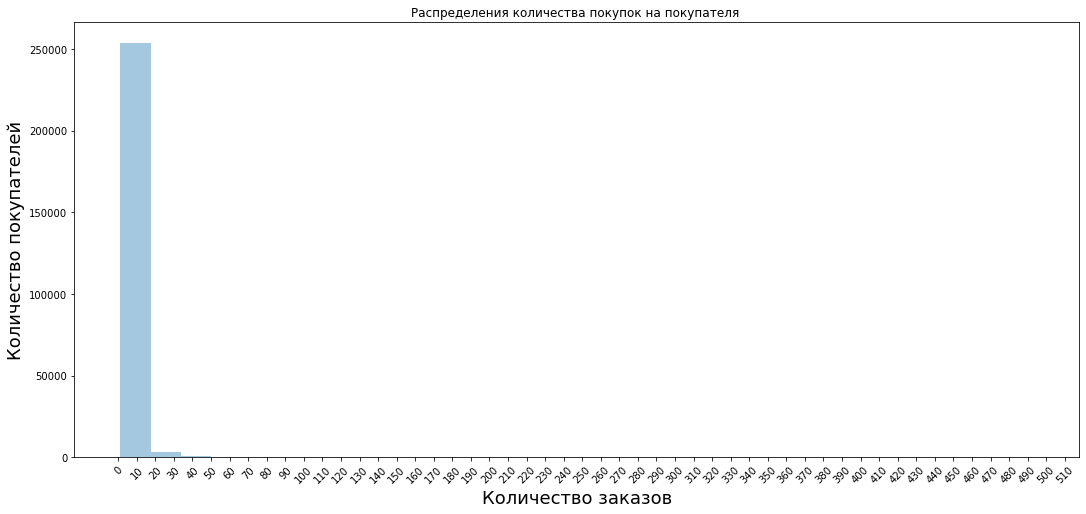

In [212]:
# Построим график распределения количества покупок на покупателя 
ax = sns.distplot(n_orders, kde=False, hist=True, bins=30)
ax.set(title='Распределения количества покупок на покупателя ',
       xlabel='Количество заказов', 
       ylabel='Количество покупателей')
plt.xticks(np.arange(0, 520, 10), rotation=45);

В большинство покупателей в среднем совершают 10 заказов.

In [213]:
n_orders_on_regions= orders_w_regions.groupby(['user_id', 'name'])['id'].nunique()
n_orders_on_regions

user_id  name              
31       Москва                41
45       Москва                31
63       Московская область     1
167      Москва                37
176      Москва                 1
                               ..
1837005  Москва                 1
1837043  Москва                 1
1837423  Москва                 1
1837462  Москва                 1
1837484  Москва                 1
Name: id, Length: 259330, dtype: int64

### Распределение заказов под дням

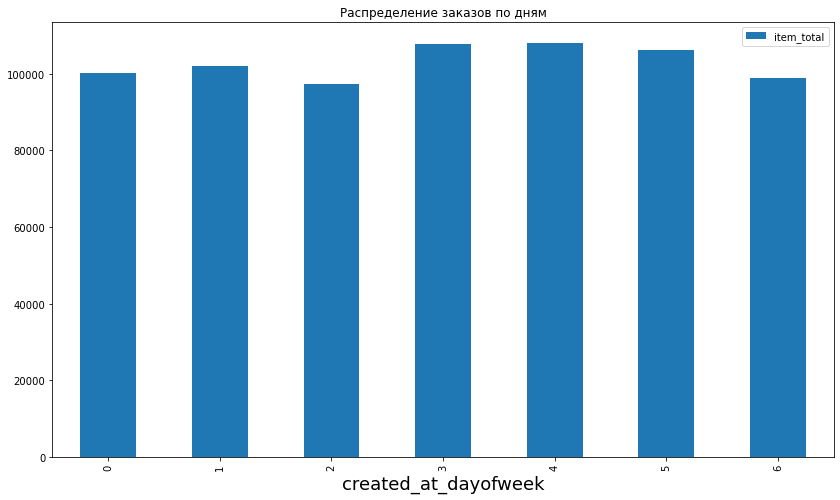

In [214]:
fig = plt.figure(figsize=(14,8))
orders.groupby('created_at_dayofweek')['item_total'].count().plot(kind='bar')
plt.title('Распределение заказов по дням')
plt.legend();

Значительных различий в покупательском поведении по дням недели не видно.

### Распределение заказов под часам

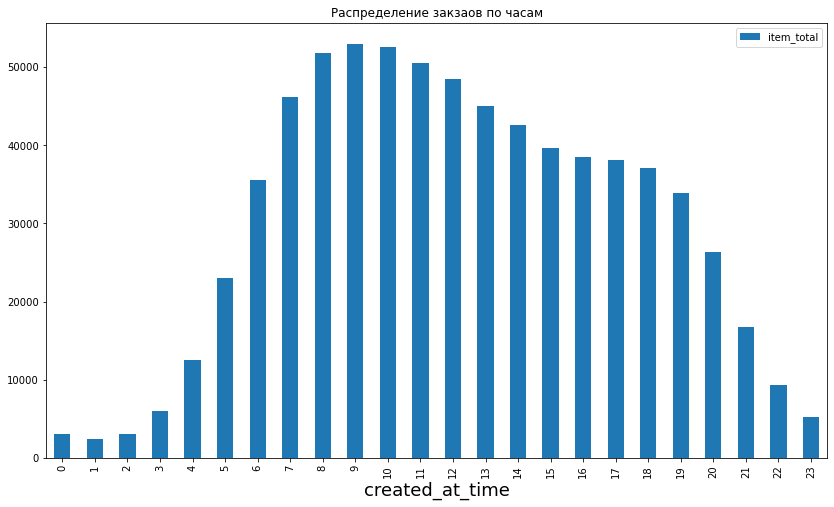

In [215]:
fig = plt.figure(figsize=(14,8))
orders.groupby('created_at_time')['item_total'].count().plot(kind='bar')
plt.title('Распределение закзаов по часам')
plt.legend();

Основное время формирования заказов с 07-12. Вероятно, чтобы доставка была осуществлена к концу раб.дня

### Распределение заказов и доставок по дням недели

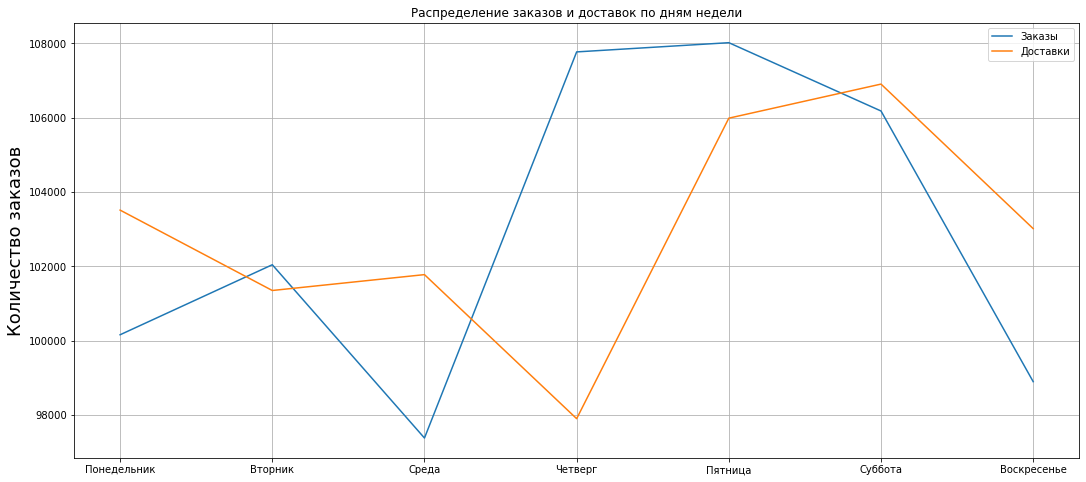

In [216]:
days_of_week = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

day_of_created = orders.groupby('created_at_dayofweek')['item_total'].count()
day_of_shipped = orders.groupby('shipped_at_dayofweek')['item_total'].count()

plt.plot(day_of_created)
plt.plot(day_of_shipped)

plt.title('Распределение заказов и доставок по дням недели')
plt.ylabel('День недели')
plt.ylabel('Количество заказов')
plt.legend(['Заказы', 'Доставки'])
plt.xticks(range(7), days_of_week)
plt.grid();

Во вторник, четверг, пятницу доставок получилось меньше, чем заказов. А вот в среду, субботу, воскресенье доставок больше.
Вероятно людям удобнее забирать заказ в выходной

### Распределение заказов и доставок по месяцам

In [217]:
orders_pivot = (
    orders
        .pivot_table(index ='created_at_month', 
                     aggfunc={'item_total':'sum', 
                              'user_id':'count'})
        .rename(columns={'user_id':'count_items'})
        .reset_index()

)
orders_pivot.head()

,created_at_month,item_total,count_items
0,2018-08,14280126,3236
1,2018-09,78031661,16711
2,2018-10,92770212,19426
3,2018-11,94372817,19810
4,2018-12,84682164,17287


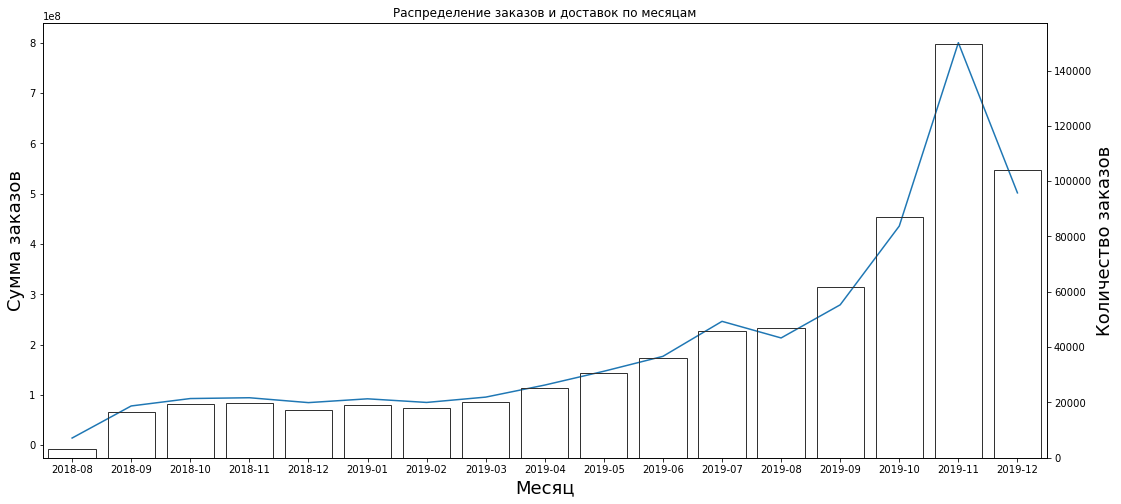

In [218]:
x = np.arange(0, len(orders_pivot), 1)

fig, ax = plt.subplots()

sns.lineplot(x=x, y='item_total', data=orders_pivot, ax=ax)
ax2 = ax.twinx()
sns.barplot(x=x, y='count_items', data=orders_pivot, ax=ax2, color='b', errcolor=".2", edgecolor=".2", facecolor=(1, 1, 1, 0))
ax2.set_xticks(x)
ax2.set_xticklabels(orders_pivot['created_at_month'])
ax.set_ylabel('Сумма заказов')
ax.set_xlabel('Месяц')
ax2.set_ylabel('Количество заказов')
plt.title('Распределение заказов и доставок по месяцам');

Видна взаимосвязь среднего чека с количеством заказов

### Сравним заказы с использованием промокодов и без них

In [219]:
orders_w_regions['promo_total'].isna().sum()

0

In [220]:
mean_sum_wo_promo = orders_w_regions.query('promo_total == 0')['item_total'].mean()
mean_sum_wo_promo

4998.667022703363

In [221]:
mean_sum_w_promo = orders_w_regions.query('promo_total < 0')['item_total'].mean()
mean_sum_w_promo

4538.54240683579

In [225]:
abs(orders_w_regions['promo_total'].mean())

51.43437112125635

Средний размер заказа без промокода равен практически 5000, без промокода 4500. При этом средний разсер скидки на товары 50р. Условно можно сказать, что скидка мотивирует на более высокую стоимость покупку. 
Необходимо сравнить эти данные по регионам.

### Сумма промо-кодов на доставку

In [ ]:
# Так как одна из составляющих выручки сервиса - это услуги по доставке, то попробуем посчитать показатель выручки по доставке

In [226]:
orders_w_regions['cost'] = orders_w_regions['cost'].astype('float32')
orders_w_regions['total_cost'] = orders_w_regions['cost'].astype('float32')

In [229]:
total_delivery_cost = orders['cost'].sum()
print(f'Общая стоимость услуг по доставке: {total_delivery_cost/1e6:.2f} млн.руб')

Общая стоимость услуг по доставке: 181.88 млн.руб


In [230]:
income_delivery_cost = orders['total_cost'].sum() 
print(f'Cтоимость услуг по доставке c учетом промо-кодов: {income_delivery_cost/1e6:.2f}, млн.руб')

Cтоимость услуг по доставке c учетом промо-кодов: 123.79, млн.руб


In [231]:
promo_delivery = total_delivery_cost - income_delivery_cost
print(f'Сумма примененных промо-кодов на доставку: {promo_delivery/1e6:.2f}, млн.руб')

Сумма примененных промо-кодов на доставку: 58.09, млн.руб


Видим что около 30% от общей суммы выручки по доставке были использованы в качстве промо-кодов. Вероятно масштабная выдача промо-кодов используется для привлечения большего числа клиентов, завоевания доли рынка, увеличения общего числа заказов.

## Заказы по регионам и месяцам

In [273]:
orders_w_regions

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,...,delivery_window_id,created_at_month,created_at_dayofweek,created_at_year,created_at_time,shipped_at_month,shipped_at_dayofweek,shipped_at_year,name,created_at_Y_M_d
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,226459,2018-08,6,2018,2,2018-08,6,2018,Москва,2018-08-26
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,...,226460,2018-08,6,2018,5,2018-08,6,2018,Москва,2018-08-26
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,...,226459,2018-08,6,2018,6,2018-08,6,2018,Москва,2018-08-26
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,...,226462,2018-08,6,2018,6,2018-08,6,2018,Москва,2018-08-26
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,...,226458,2018-08,6,2018,7,2018-08,6,2018,Москва,2018-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720428,5423310,1676786,258.0,258.0,4777,0.0,43286,71,shipped,2019-12-18 15:45:12,...,973254,2019-12,2,2019,9,2019-12,2,2019,Омская область,2019-12-18
720429,5423488,1832586,238.0,238.0,1864,0.0,4245,13,shipped,2019-12-18 12:44:16,...,973253,2019-12,2,2019,9,2019-12,2,2019,Омская область,2019-12-18
720430,5424466,1318477,238.0,238.0,2769,-200.0,4780,7,shipped,2019-12-18 13:16:08,...,973252,2019-12,2,2019,9,2019-12,2,2019,Омская область,2019-12-18
720431,5426016,1116106,238.0,238.0,2876,0.0,13385,34,shipped,2019-12-18 14:28:56,...,973254,2019-12,2,2019,10,2019-12,2,2019,Омская область,2019-12-18


In [232]:
cnt_orders_on_regions = (
    orders_w_regions
    .groupby(['created_at_month', 'name'], as_index=False)['user_id']
    .count()
    .rename(columns={'user_id': 'count_orders'})
)

In [233]:
cnt_orders_on_regions.head()

,created_at_month,name,count_orders
0,2018-08,Москва,2952
1,2018-08,Московская область,103
2,2018-08,Татарстан,177
3,2018-09,Москва,15362
4,2018-09,Московская область,497


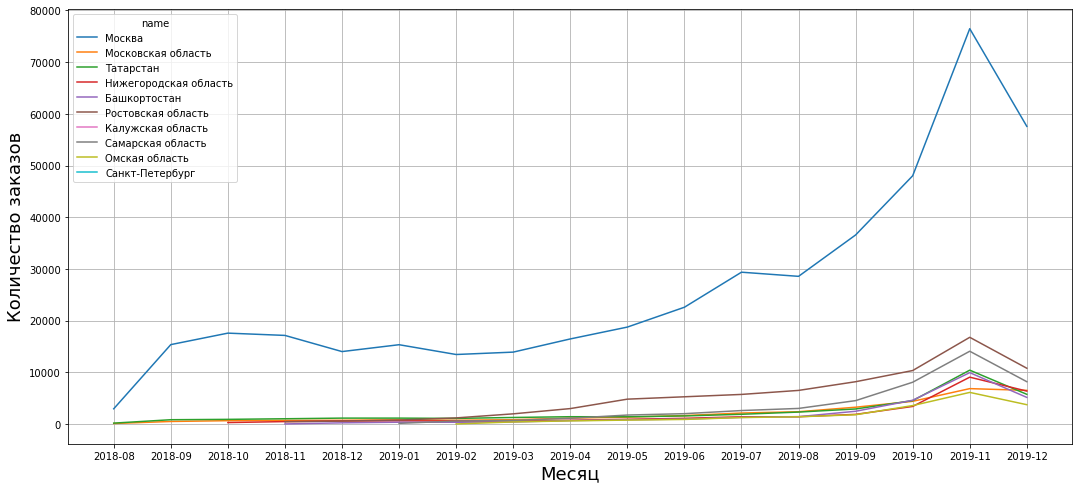

In [234]:
fig, ax = plt.subplots()

# Количество заказов в разрезе регионов (месячная разбивка)
sns.lineplot(x='created_at_month', 
             y='count_orders', 
             data=cnt_orders_on_regions, 
             hue='name'
            )
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid();

Как и следовало ожидать - большинство заказов из Москвы. Есть месяц (2019-07), где заказы по месяцу или вышли на плато или, как в случае с Москвой, упали.Посмотрим далее на остальные регионы без Москвы

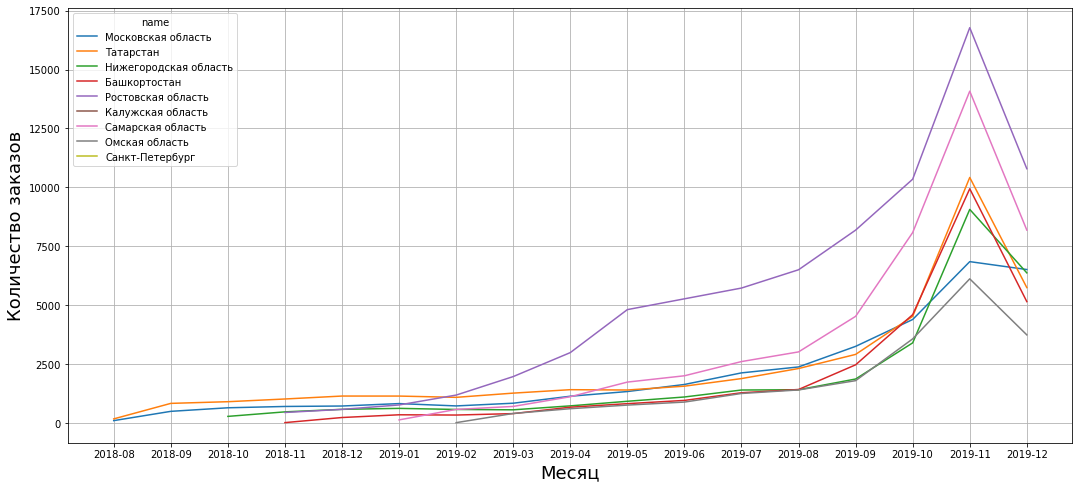

In [236]:
fig, ax = plt.subplots()

# Количество заказов в разрезе регионов, без учета Москвы
sns.lineplot(x='created_at_month', 
             y='count_orders', 
             data=cnt_orders_on_regions.query('name not in ["Москва"]'), 
             hue='name'
            )
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid();

Вторая по объему заказов - Ростовская область. По всем графикам видна одна тенденция к росту объема продаж, ели не брать последний месяц, т.к там явно не все данные.

In [29]:
# fig, ax = plt.subplots()

# # Количество заказов в разрезе регионов
# sns.lineplot(x='created_at_month', 
#              y='count_orders', 
#              data=cnt_orders_on_regions.query('created_at_month in "2019-05" and name !="Москва"'), 
#              hue='name'
#             )
# plt.grid();

In [237]:
# Создадим вспомогательный признак, который будет отражать Год, месяц, день создания заказа.
orders_w_regions['created_at_Y_M_d'] = orders_w_regions['created_at'].dt.strftime('%Y-%m-%d')

In [238]:
#Проверим период 2019-07, в котором видна "просадка" в заказах по МСК.
count_ord = orders_w_regions.groupby(['created_at_Y_M_d', 'name'], as_index=False)['id'].count()
count_ord

,created_at_Y_M_d,name,id
0,2018-08-26,Москва,504
1,2018-08-26,Московская область,21
2,2018-08-26,Татарстан,26
3,2018-08-27,Москва,536
4,2018-08-27,Московская область,20
...,...,...,...
3293,2019-12-18,Нижегородская область,165
3294,2019-12-18,Омская область,89
3295,2019-12-18,Ростовская область,241
3296,2019-12-18,Самарская область,195


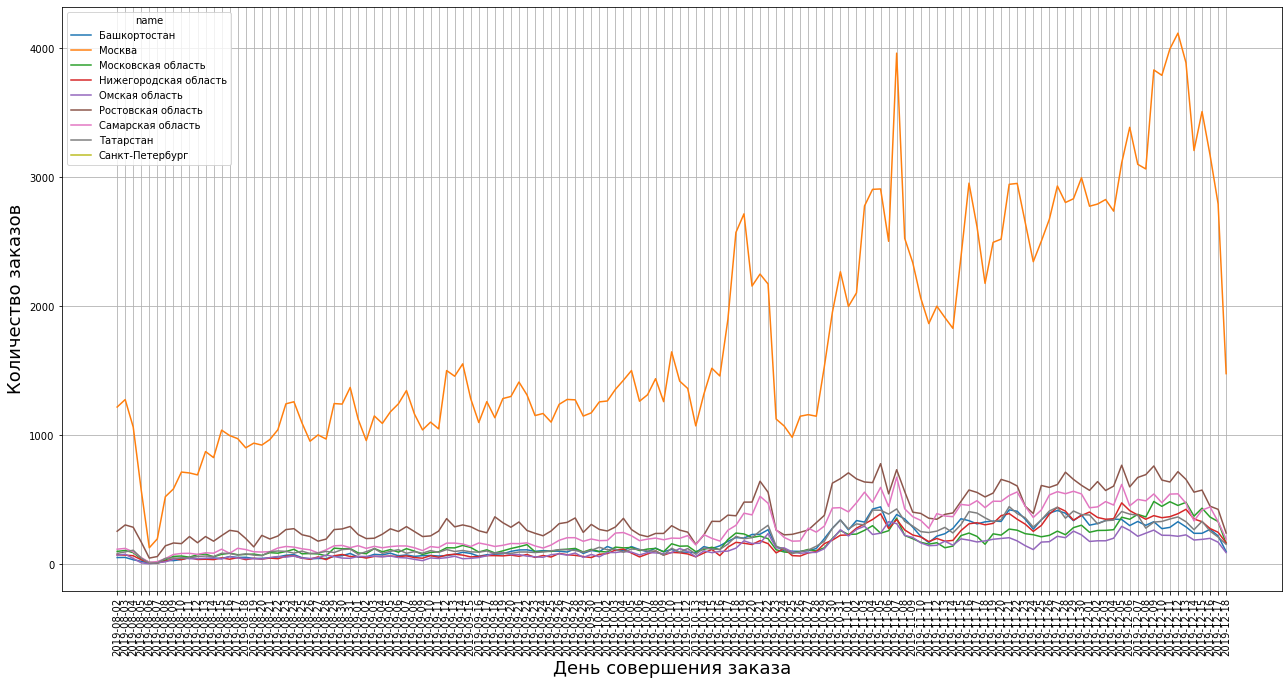

In [252]:
fig, ax = plt.subplots()

# Количество заказов в разрезе регионов(ежедневная разбивка)
sns.lineplot(x='created_at_Y_M_d', 
             y='id', 
             data=count_ord.query('created_at_Y_M_d > "2019-08-01"'), 
             hue='name'
            )
plt.xticks(rotation=90)
plt.xlabel('День совершения заказа')
plt.ylabel('Количество заказов')
plt.tight_layout()
fig.set_figwidth(18)
fig.set_figheight(10)
plt.grid();

На графике видны как минимум 3 значительные падения заказов, причем они применимы для всех всех регионов. Возможным объяснение может быть недоступность сервиса для заказов.

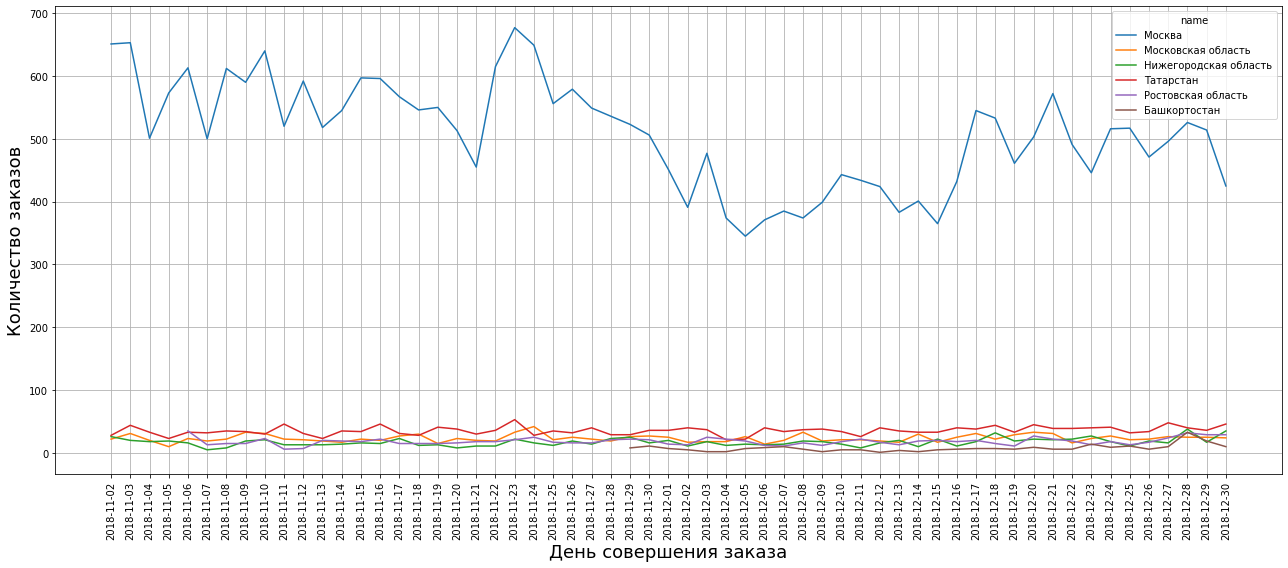

In [253]:
# Посмотрим более детально период просадки, который увидели на месячном графике
fig, ax = plt.subplots()

# Количество заказов в разрезе регионов
sns.lineplot(x='created_at_Y_M_d', 
             y='id', 
             data=count_ord.query('created_at_Y_M_d > "2018-11-01" and created_at_Y_M_d < "2018-12-31"'), 
             hue='name'
            )
plt.xticks(rotation=90)
plt.xlabel('День совершения заказа')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.grid();

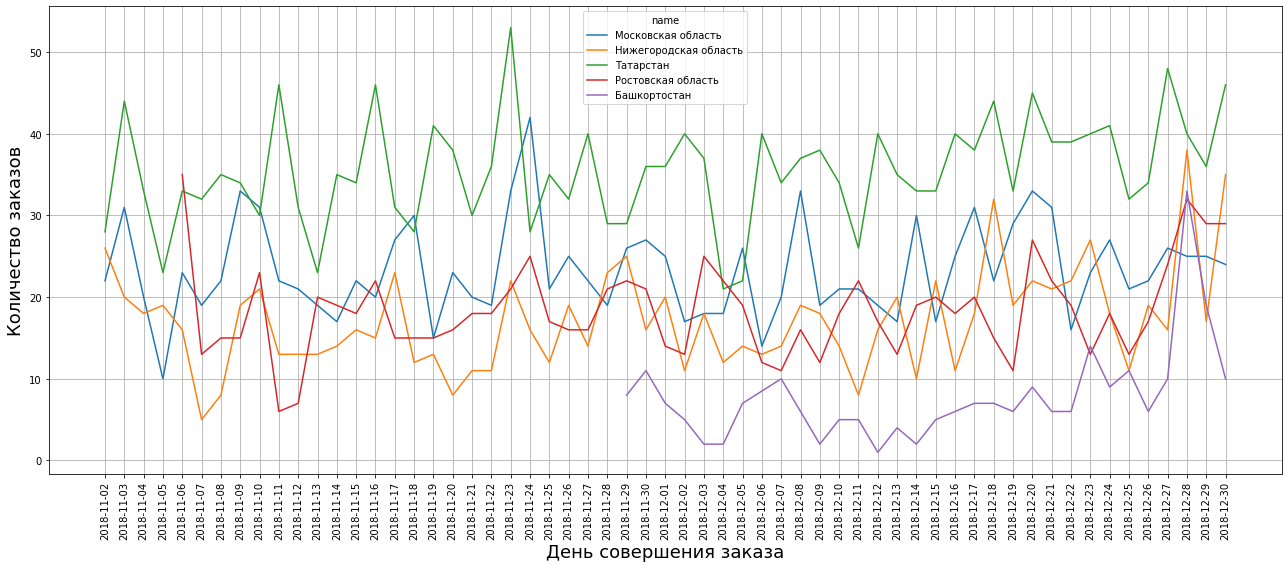

In [255]:
fig, ax = plt.subplots()

# Количество заказов в разрезе регионов, без Москвы
sns.lineplot(x='created_at_Y_M_d', 
             y='id', 
             data=count_ord.query('created_at_Y_M_d > "2018-11-01" and created_at_Y_M_d < "2018-12-31" and name != "Москва"'), 
             hue='name'
            )
# y= count_ord['id']

# for index, value in enumerate(y):
#     plt.text(index, value, str(value), fontweight='ultralight', ha='center')

plt.xticks(rotation=90)
plt.xlabel('День совершения заказа')
plt.ylabel('Количество заказов')
plt.tight_layout()
plt.grid();

На графике заметна просадка по заказам, которая продолжалась примерно с 2018-11-27 до 2018-12-03. Возможно это также связано с недоступностью или нестабильной работой сервиса.

### Cредняя сумма заказа по регионам

In [256]:
orders_w_regions.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,...,delivery_window_id,created_at_month,created_at_dayofweek,created_at_year,created_at_time,shipped_at_month,shipped_at_dayofweek,shipped_at_year,name,created_at_Y_M_d
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,...,226459,2018-08,6,2018,2,2018-08,6,2018,Москва,2018-08-26
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,...,226460,2018-08,6,2018,5,2018-08,6,2018,Москва,2018-08-26
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,...,226459,2018-08,6,2018,6,2018-08,6,2018,Москва,2018-08-26
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,...,226462,2018-08,6,2018,6,2018-08,6,2018,Москва,2018-08-26
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,...,226458,2018-08,6,2018,7,2018-08,6,2018,Москва,2018-08-26


In [274]:
mean_orders = (
    orders_w_regions
    .groupby(['name'], as_index=False)['item_total']
    .mean()
    .sort_values('item_total', ascending=False)
)

In [275]:
mean_orders

,name,item_total
3,Московская область,5590.131660
2,Москва,5493.428298
1,Калужская область,4300.000000
4,Нижегородская область,3915.848159
9,Татарстан,3911.362492
7,Самарская область,3875.444613
0,Башкортостан,3871.219688
5,Омская область,3767.313715
6,Ростовская область,3689.266566
8,Санкт-Петербург,1098.000000


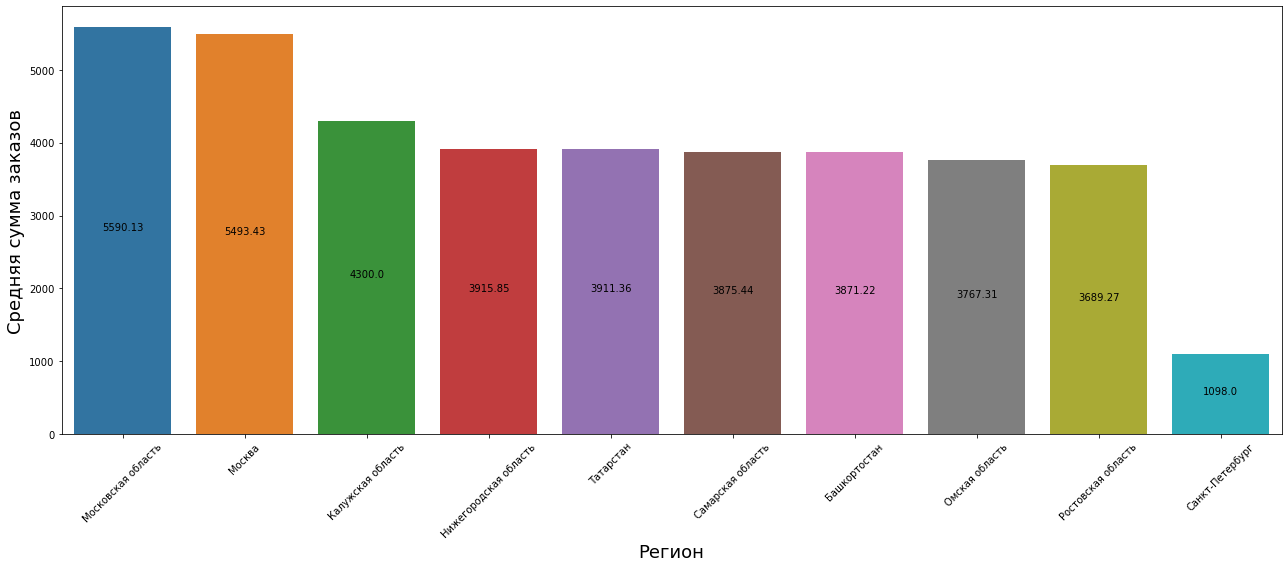

In [276]:
# Средний чек по регионам
fig, ax = plt.subplots()


sns.barplot(x='name', 
            y='item_total', 
             data=mean_orders, 
            )

y= round(mean_orders['item_total'], 2)

for index, value in enumerate(y):
    plt.text(index, value//2, str(value), fontweight='ultralight', ha='center')
    
plt.xticks(rotation=45)
plt.xlabel('Регион')
plt.ylabel('Средняя сумма заказов')
plt.tight_layout();

Самый высокий средний чек оказался в МО, даже не в Москве. В отстающих регионах - Санкт-Петербург, что немного странно. 

In [261]:
mean_orders_month = orders_w_regions.groupby(['name', 'created_at_month'], as_index=False)['item_total'].mean().sort_values('item_total', ascending=False)

In [264]:
mean_orders_month.head(20)

,name,created_at_month,item_total
47,Московская область,2019-11,6908.257848
30,Москва,2019-11,6306.397123
26,Москва,2019-07,6040.287636
46,Московская область,2019-10,5905.509331
29,Москва,2019-10,5735.907347
43,Московская область,2019-07,5668.854861
48,Московская область,2019-12,5544.327449
25,Москва,2019-06,5526.015671
24,Москва,2019-05,5475.343537
31,Москва,2019-12,5469.986347


### Средний чек по регионам в разрезе месяцев

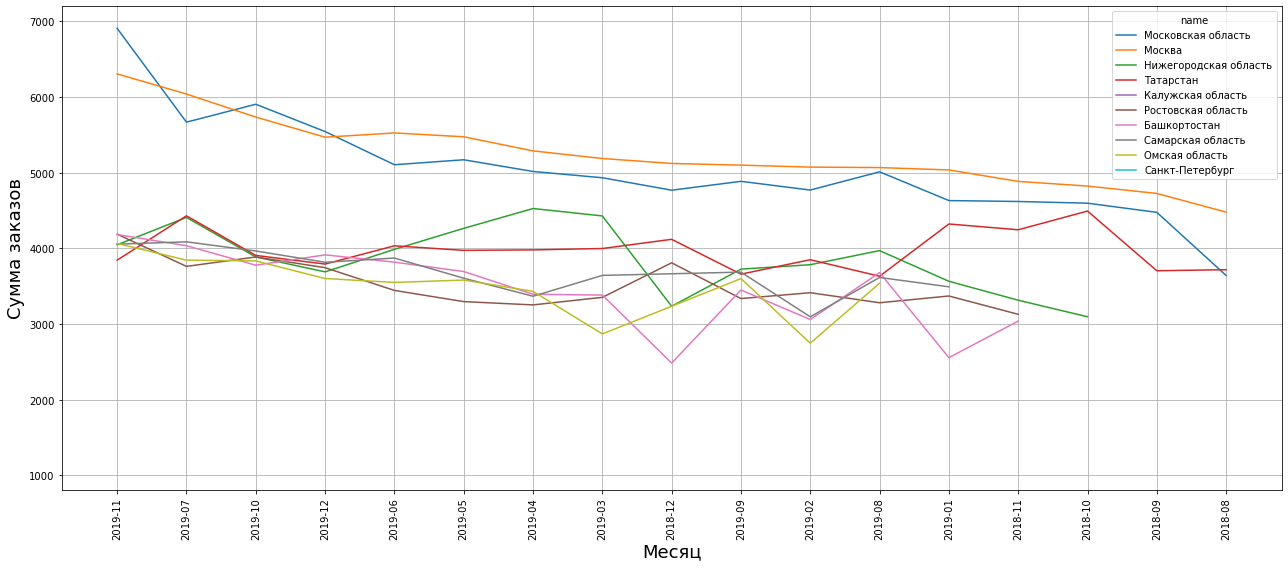

In [265]:
# Средний чек по регионам в разрезе месяцев
fig, ax = plt.subplots()

sns.lineplot(x='created_at_month', 
            y='item_total', 
            data=mean_orders_month,
            hue='name'
            )
plt.xticks(rotation=90)
plt.xlabel('Месяц')
plt.ylabel('Сумма заказов')
plt.grid()
plt.tight_layout();

Самую высоку помесячную динанимку роста среднего чека демонстрирует Нижегородская область, если не брать в расчет 2 региона лидера - Москву и МО.
По всем регионам видна тенденция снижения среднего чека.

### Сколько единиц продуктов в среднем заказывают в регионах

In [266]:
mean_quantitry_orders = (
    orders_w_regions
    .groupby(['name', 'created_at_month'], as_index=False)['total_quantity']
    .mean()
)
mean_quantitry_orders

,name,created_at_month,total_quantity
0,Башкортостан,2018-11,24.157895
1,Башкортостан,2018-12,18.310638
2,Башкортостан,2019-01,17.421652
3,Башкортостан,2019-02,26.000000
4,Башкортостан,2019-03,29.705736
...,...,...,...
114,Татарстан,2019-08,34.506914
115,Татарстан,2019-09,39.542053
116,Татарстан,2019-10,37.380742
117,Татарстан,2019-11,33.684837


In [267]:
plot_order = mean_quantitry_orders.sort_values(by='created_at_month', ascending=True)['created_at_month'].unique()

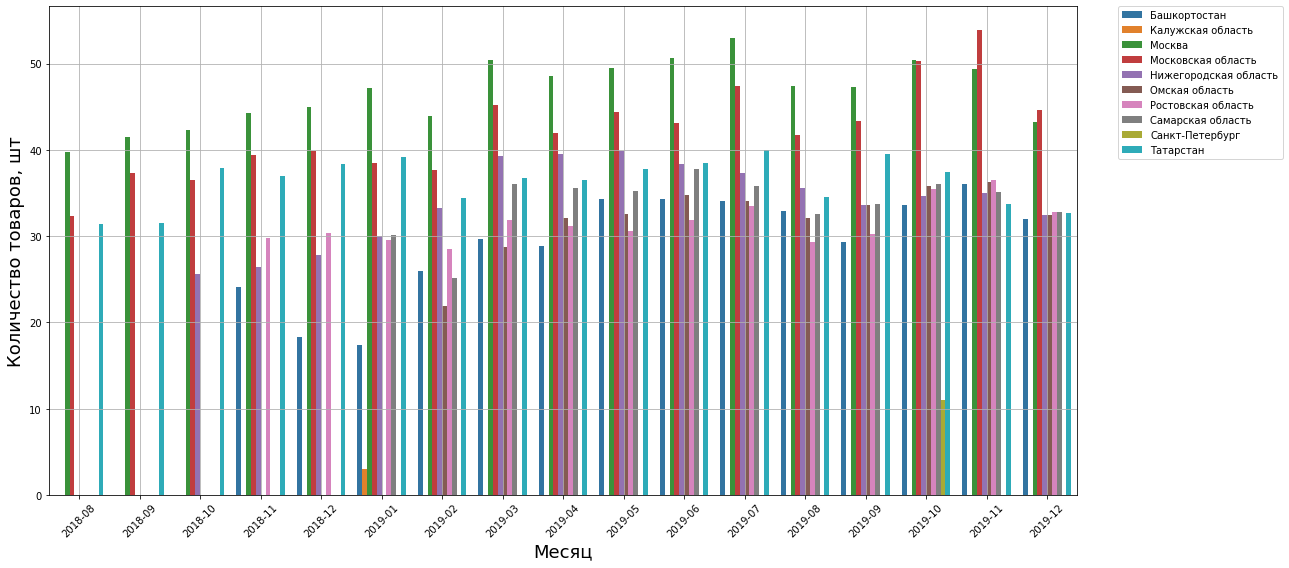

In [270]:
fig, ax = plt.subplots()

sns.barplot(x='created_at_month', 
            y='total_quantity', 
            data=mean_quantitry_orders,
            hue='name',
            order=plot_order,
            )
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Количество товаров, шт')
plt.legend(loc='upper left', 
           bbox_to_anchor=(1.04,1), 
           borderaxespad=0)
plt.grid()
plt.tight_layout();

In [271]:
mean_quantitry_orders.total_quantity.mean()

35.829147546524254

In [272]:
mean_quantitry_orders.groupby('name')['total_quantity'].mean()

name
Башкортостан             29.358727
Калужская область         3.000000
Москва                   46.670804
Московская область       42.205615
Нижегородская область    33.915771
Омская область           32.229311
Ростовская область       31.533556
Самарская область        33.834118
Санкт-Петербург          11.000000
Татарстан                36.294651
Name: total_quantity, dtype: float64

В среднем покупатели заказывают 36 товаров за 1 покупку. Больше всего в Москве и области. Меньше всего Калужской области и Санкт_Петебрурге. Это может быть связано как с высокой конкуренцией в сфере доставки продуктов , если говорить о Санкт-Петербурге, так и о еще не сформировавшейся привычке "что-то заказывать в магазине с доставкой" на примере Калужской области. 

### Средняя продолжительность между заказами (окно - 1 месяц).

In [277]:
temp_df = orders_w_regions.sort_values(['created_at'])[['id', 'user_id', 'created_at', 'created_at_month', 'shipped_at']]
temp_df.head(30)

,id,user_id,created_at,created_at_month,shipped_at
274801,756914,81165,2018-08-26 00:05:41,2018-08,2018-08-26 16:18:05
380700,756916,4225,2018-08-26 00:07:14,2018-08,2018-08-26 11:13:14
0,756927,139676,2018-08-26 02:06:55,2018-08,2018-08-26 15:01:42
129874,756933,139671,2018-08-26 03:36:34,2018-08,2018-08-27 19:07:11
97068,756934,139672,2018-08-26 03:46:09,2018-08,2018-08-28 15:54:03
274802,756939,53480,2018-08-26 04:24:13,2018-08,2018-08-27 15:06:01
129875,756940,80224,2018-08-26 04:30:28,2018-08,2018-08-29 08:47:14
421526,756941,55823,2018-08-26 04:38:27,2018-08,2018-08-26 13:33:53
380701,756942,139689,2018-08-26 04:51:32,2018-08,2019-10-18 17:44:32
175473,756944,139680,2018-08-26 05:00:05,2018-08,2018-08-26 17:43:40


In [299]:
# Проверка
# temp_df = temp_df.query('user_id in [81165]')
# temp_df

In [278]:
# Оставляет только тех клиентов, которые слелали больше 1 заказа

mask_users = temp_df.groupby('user_id', as_index=False)['id'].count().query('id > 1')[['user_id']]
mask_users

,user_id
0,31
1,45
3,167
6,203
8,333
...,...
257161,1831309
257337,1832556
257429,1833088
257433,1833120


In [279]:
users_idx = mask_users.user_id.values

In [280]:
temp_df = temp_df.loc[temp_df['user_id'].isin(users_idx)]

In [281]:
temp_df['days_bw_orders'] = temp_df.groupby(['user_id'])['created_at'].diff().dt.days

In [49]:
# temp_df.query('user_id == 81165')

In [282]:
mean_days_bw_ord = temp_df.groupby(['created_at_month'], as_index=False)['days_bw_orders'].median()
mean_days_bw_ord

,created_at_month,days_bw_orders
0,2018-08,1.0
1,2018-09,7.0
2,2018-10,10.0
3,2018-11,10.0
4,2018-12,12.0
5,2019-01,12.0
6,2019-02,12.0
7,2019-03,12.0
8,2019-04,13.0
9,2019-05,12.0


In [283]:
# Среднее количество дней между покупками

temp_df['days_bw_orders'].median()

10.0

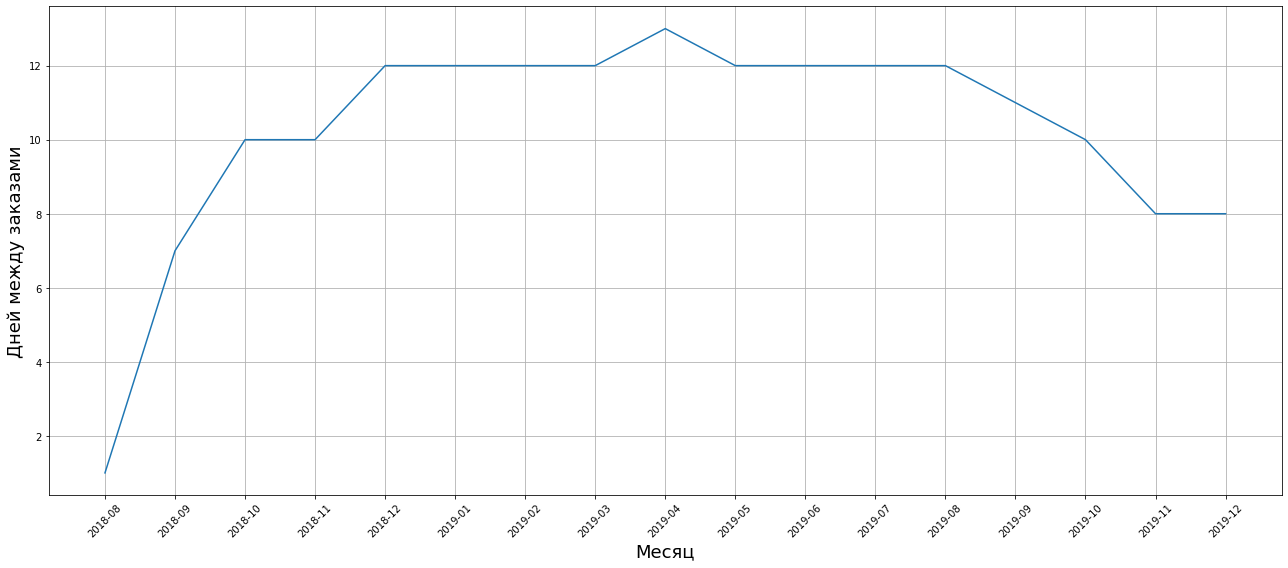

In [284]:
fig, ax = plt.subplots()

sns.lineplot(x='created_at_month', 
            y='days_bw_orders', 
            data=mean_days_bw_ord,
            )
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Дней между заказами')
plt.grid()
plt.tight_layout();

Среднее количество дней между заказами во временном окне 1 месяц неуклонно росло с момента начала наблюдения до октября 2019. Затем этот показатель начал снижаться.

In [296]:
del temp_df

##  Опоздания(какой магазин, какой регион)

In [285]:
delivery_windows.head()

,store_id,id,starts_at,ends_at,time_zone
0,1,226459,2018-08-26 14:00:00,2018-08-26 16:00:00,Europe/Moscow
1,1,226460,2018-08-26 15:00:00,2018-08-26 17:00:00,Europe/Moscow
2,1,226462,2018-08-26 17:00:00,2018-08-26 19:00:00,Europe/Moscow
3,1,226458,2018-08-26 13:00:00,2018-08-26 15:00:00,Europe/Moscow
4,1,227250,2018-08-27 15:00:00,2018-08-27 17:00:00,Europe/Moscow


In [287]:
# orders_w_regions_late = reduce_mem_usage(orders_w_regions_late)

In [288]:
#Добавляем данные об опозданиях в датасет заказов
orders_w_regions_late = pd.merge(orders_w_regions, delivery_windows[['starts_at','ends_at','id']], left_on='delivery_window_id', right_on='id')

In [289]:
# Рассчитываем время опозданий
orders_w_regions_late['b_late'] = (orders_w_regions_late['ends_at'] - orders_w_regions_late['shipped_at']).astype('timedelta64[m]')

In [290]:
late_orders = orders_w_regions_late.query('b_late < 0').count()['user_id']
print(f'Количество заказов доставленных с опозданием {late_orders}, шт')

Количество заказов доставленных с опозданием 132960, шт


In [291]:
total_orders = orders_w_regions_late.count()['user_id']

In [292]:
perc_late_orders = late_orders / total_orders
print(f'Процент заказов доставленных с опозданием: {100 * perc_late_orders:.2f}%')

Процент заказов доставленных с опозданием: 18.46%


In [315]:
## Посмотрим на распределение по опоздавшим заказам в разрезе регионов.

In [293]:
orders_w_regions_late.query('b_late < 0').groupby(['shipped_at_month', 'name'])['user_id'].count()

shipped_at_month  name                 
2018-08           Москва                    244
                  Московская область          8
                  Татарстан                  25
2018-09           Москва                   2075
                  Московская область         89
                                           ... 
2019-12           Нижегородская область    1635
                  Омская область            519
                  Ростовская область       1470
                  Самарская область        1083
                  Татарстан                 626
Name: user_id, Length: 116, dtype: int64

In [294]:
df_late_orders = (
    orders_w_regions_late
    .groupby(['shipped_at_month', 'name'], as_index=False)
    .agg({'user_id': (lambda x: len(x)),
         'b_late': (lambda x: x[x<0].count())})
    .rename(columns={'user_id': 'count_orders', 'b_late': 'late_orders'})
)                                                           

In [295]:
df_late_orders

,shipped_at_month,name,count_orders,late_orders
0,2018-08,Москва,1924,244.0
1,2018-08,Московская область,64,8.0
2,2018-08,Татарстан,132,25.0
3,2018-09,Москва,14602,2075.0
4,2018-09,Московская область,454,89.0
...,...,...,...,...
114,2019-12,Нижегородская область,7094,1635.0
115,2019-12,Омская область,4267,519.0
116,2019-12,Ростовская область,12124,1470.0
117,2019-12,Самарская область,9279,1083.0


In [296]:
df_late_orders= df_late_orders.assign(percent_late_orders = (df_late_orders.late_orders / df_late_orders.count_orders)*100)

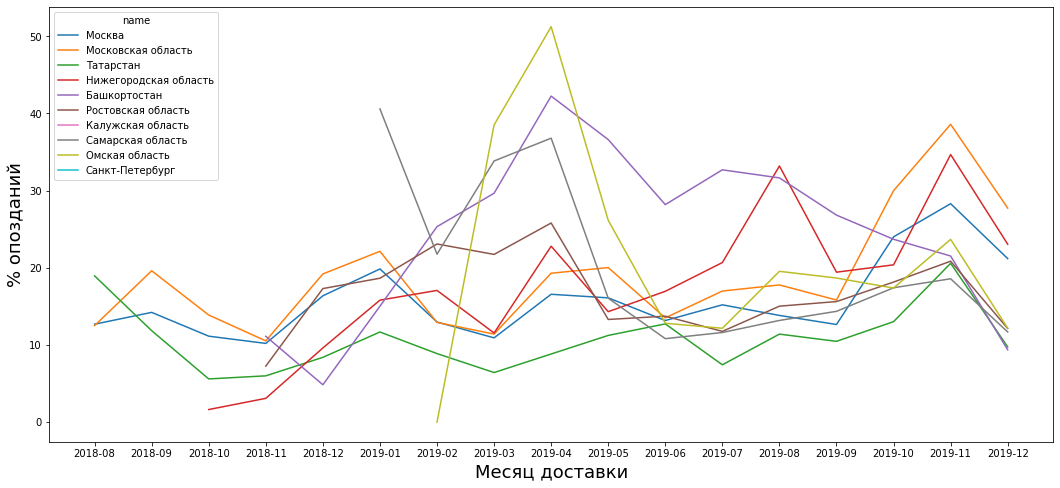

In [297]:
fig, ax = plt.subplots()
sns.lineplot(x='shipped_at_month', 
             y='percent_late_orders', 
             hue='name', 
             data=df_late_orders)
plt.xlabel('Месяц доставки')
plt.ylabel('% опозданий');

По графику видна сильная волатильность в проценте не доставленных в срок заказов. Самым выделяющимся является Омская область, в ней процент опозданий варьировался с 30 до 50, на протяжении 2-х месяцев. Затем ситуация стабилизировалась. Вероятно это связано с периодом запуска, когда не все процессы были отлажены. Один из самых стабильных регионов-Татарстан.

### Проверим на сколько минут в среднем отклонялись заказы в регионе лидере и аутсайдере

In [298]:
omsk_mean_late = orders_w_regions_late.query('name == "Омская область" and b_late < 0')['b_late'].mean()

In [299]:
print(f'Среднее время опозданий в Омске {abs(omsk_mean_late) / 60:.2f}ч')

Среднее время опозданий в Омске 2.25ч


In [300]:
tatarstan_mean_late = orders_w_regions_late.query('name == "Татарстан" and b_late < 0')['b_late'].mean()

In [301]:
print(f'Среднее время опозданий в Татарстане {abs(tatarstan_mean_late) / 60:.2f}ч')

Среднее время опозданий в Татарстане 1.07ч


Разница более чем двукратная. Необходимо снижать как процент опозданий, так и среднее время, так как эти показатели напрямую влияют на возвращаемость в сервис.

### Из каких магазинов чаще всего были задержки доставки

In [303]:
late_orders_store = (
    orders_w_regions_late
    .query('b_late < 0')
    .groupby(['name', 'store_id', 'created_at_month'], as_index=False)
    .agg({'b_late':'count'})
    .rename(columns={'b_late': 'count_late'})
    .sort_values('count_late', ascending=False)
)

In [337]:
late_orders_store[late_orders_store['count_late'] > 50].head(30)
# В первой тридцатки большинстов магазинов из Москвы, это обусловлено  количеством заказов, т.к Москва самый крупный регион.

,name,store_id,created_at_month,count_late
37,Москва,1,2019-11,3585
173,Москва,14,2019-11,3492
88,Москва,8,2019-11,2406
36,Москва,1,2019-10,2128
122,Москва,10,2019-11,2106
139,Москва,11,2019-11,1916
172,Москва,14,2019-10,1645
174,Москва,14,2019-12,1498
55,Москва,2,2019-12,1393
12,Башкортостан,98,2019-11,1321


In [ ]:
# Хорошо бы еще проверить опоздания по временным интервалам, так как для большинства клиентов опоздание на 5-10 это приемлемо, а если опоздание более 1 часа, то это уже может быть критичным и плохо скажется на оттоке клиентов.

## Замены товаров и отмены заказов

In [338]:
replacements

,order_id,item_id,state
0,480785,6466916,replaced
1,480785,6466940,replaced
2,480785,6466778,replaced
3,480785,6466825,replaced
4,480786,7261201,replaced
...,...,...,...
1250239,5426016,89177585,replaced
1250240,5426016,89169966,replaced
1250241,5426016,89163589,replaced
1250242,5426868,89272519,replaced


In [339]:
repl_df = orders_w_regions.copy()
repl_df

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,...,delivery_window_id,created_at_month,created_at_dayofweek,created_at_year,shipped_at_month,shipped_at_dayofweek,shipped_at_year,name,created_at_Y_M_d,shipped_at_Y_M_d
274801,756914,81165,299.0,299.0,2395,0.00,30000,30,shipped,2018-08-26 16:18:05,...,226589,2018-08,6,2018,2018-08,6,2018,Москва,2018-08-26,2018-08-26
380700,756916,4225,249.0,249.0,4130,0.00,26104,48,shipped,2018-08-26 11:13:14,...,226658,2018-08,6,2018,2018-08,6,2018,Москва,2018-08-26,2018-08-26
0,756927,139676,0.0,0.0,5015,0.00,37708,39,shipped,2018-08-26 15:01:42,...,226459,2018-08,6,2018,2018-08,6,2018,Москва,2018-08-26,2018-08-26
129874,756933,139671,0.0,0.0,1779,-138.75,8850,5,shipped,2018-08-27 19:07:11,...,227307,2018-08,6,2018,2018-08,0,2018,Москва,2018-08-26,2018-08-27
97068,756934,139672,0.0,0.0,4986,-1139.00,24330,33,shipped,2018-08-28 15:54:03,...,228332,2018-08,6,2018,2018-08,1,2018,Москва,2018-08-26,2018-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175472,5443574,1837462,98.0,199.0,4985,0.00,8504,28,shipped,2019-12-18 19:57:02,...,969706,2019-12,2,2019,2019-12,2,2019,Москва,2019-12-18,2019-12-18
379980,5443796,1284905,193.0,294.0,4684,-250.00,46975,28,shipped,2019-12-18 21:53:21,...,969926,2019-12,2,2019,2019-12,2,2019,Москва,2019-12-18,2019-12-18
274800,5444559,464668,158.0,249.0,3955,0.00,11055,18,shipped,2019-12-18 20:18:38,...,969821,2019-12,2,2019,2019-12,2,2019,Московская область,2019-12-18,2019-12-18
239665,5444744,1266916,299.0,299.0,3365,0.00,27184,35,shipped,2019-12-18 20:51:02,...,969763,2019-12,2,2019,2019-12,2,2019,Москва,2019-12-18,2019-12-18


In [340]:
tt = repl_df.merge(replacements[['order_id', 'state']], how='left', left_on='id', right_on='order_id').drop('order_id', axis=1)

In [341]:
tt = tt.merge(cancellations[['order_id', 'state']], how='left', left_on='id', right_on='order_id').drop('order_id', axis=1)

In [342]:
tt['cancelled'] = tt[['state_y', 'state']].notnull().any(axis=1)

In [343]:
tt = tt.drop_duplicates('id')

In [347]:
pivot_cancellations = (
    tt.groupby(['created_at_month', 'name'], as_index=False)
    .agg({'cancelled': (lambda x: 100*(x[x==1].count() / x.count()))})
)

In [351]:
pivot_cancellations

,created_at_month,name,cancelled
0,2018-08,Москва,80.216802
1,2018-08,Московская область,83.495146
2,2018-08,Татарстан,90.395480
3,2018-09,Москва,77.685197
4,2018-09,Московская область,85.513078
...,...,...,...
114,2019-12,Нижегородская область,85.373509
115,2019-12,Омская область,79.256883
116,2019-12,Ростовская область,84.181262
117,2019-12,Самарская область,69.699560


NameError: name 'pivot_cancellations' is not defined

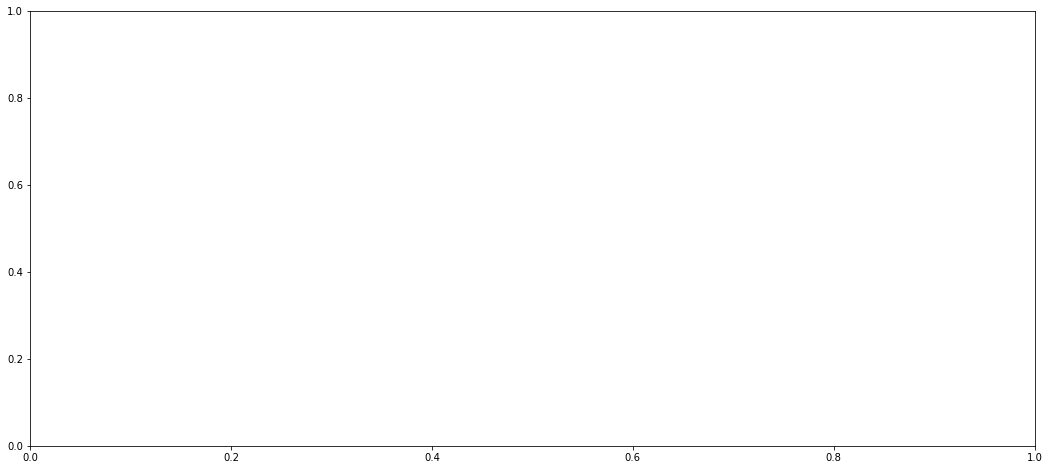

In [304]:
fig, ax = plt.subplots()
sns.lineplot(x='created_at_month', 
             y='cancelled', 
             hue='name', 
             data=pivot_cancellations)
plt.xlabel('Месяц заказа')
plt.ylabel('% замен/отмен товаров');

Наблюдаем в последних месяцах рост процента замен/отмен товаров. Причем он характерен для всех регионов. Это плохой показатель. Необходимо проанализировать, что на это повлияло. Необходимо в разрезе каждого региона, месяца и сети посмотреть как распределены проценты отмен. Возможно дело в неактуальности данных по остаткам, которые мы получаем от партнеров. Возможно стоит подумать над разработкой системы прогнозирования заказов и доступности остатков.

In [349]:
pivot_cancellations.cancelled.mean()

77.17450092892835

В среднем в 77% заказов происходят отмены или замены. Это очень высокий показатель и его также нужно снижать. Также важно понимать по какой причине была отмена или замена - то ли клиент передумал покупать товар, то ли мы не смогли обеспечить его доставку.
Также важно понимать сколько товаров было отменено или заменено из всей корзины пользователя. Т.к, если, условно, нам приходится менять кажды второй товар, то это очень негативно скажется на повторных заказах клиента.

# Когортный анализ

In [249]:
cohort_df_m = orders_w_regions.sort_values('created_at').drop_duplicates('user_id')

In [250]:
cohort_df_m['created_at'] = cohort_df_m['created_at'].dt.to_period('M')

In [251]:
cohort_df_m = cohort_df_m[['user_id', 'created_at']]
cohort_df_m.columns = ['user_id', 'cohort'] 

In [252]:
cohort_df_m

,user_id,cohort
274801,81165,2018-08
380700,4225,2018-08
0,139676,2018-08
129874,139671,2018-08
97068,139672,2018-08
...,...,...
175471,1252292,2019-12
175472,1837462,2019-12
379980,1284905,2019-12
239665,1266916,2019-12


In [ ]:
###

In [449]:
cohort_df = orders_w_regions[['user_id', 'created_at', 'item_total', 'id', 'cost']].drop_duplicates()
cohort_df

,user_id,created_at,item_total,id,cost
0,139676,2018-08-26 02:06:55,5015,756927,0.0
1,139682,2018-08-26 05:43:20,7096,756963,0.0
2,63967,2018-08-26 06:12:13,2724,756983,299.0
3,139687,2018-08-26 06:13:59,3471,756985,0.0
4,119006,2018-08-26 07:40:58,1254,757066,299.0
...,...,...,...,...,...
720428,1676786,2019-12-18 09:16:28,4777,5423310,258.0
720429,1832586,2019-12-18 09:20:18,1864,5423488,238.0
720430,1318477,2019-12-18 09:41:28,2769,5424466,238.0
720431,1116106,2019-12-18 10:18:37,2876,5426016,238.0


In [450]:
cohort_df['cohort'] = (
    cohort_df
    .groupby('user_id')['created_at']
    .transform('min')
    .dt.to_period('M')
)

In [451]:
cohort_df['created_at'] = cohort_df['created_at'].dt.to_period('M')

In [453]:
cohort_df

,user_id,created_at,item_total,id,cost,cohort
0,139676,2018-08,5015,756927,0.0,2018-08
1,139682,2018-08,7096,756963,0.0,2018-08
2,63967,2018-08,2724,756983,299.0,2018-08
3,139687,2018-08,3471,756985,0.0,2018-08
4,119006,2018-08,1254,757066,299.0,2018-08
...,...,...,...,...,...,...
720428,1676786,2019-12,4777,5423310,258.0,2019-12
720429,1832586,2019-12,1864,5423488,238.0,2019-12
720430,1318477,2019-12,2769,5424466,238.0,2019-11
720431,1116106,2019-12,2876,5426016,238.0,2019-10


In [454]:
cohort_df_transform = (
    cohort_df
    .groupby(['cohort', 'created_at']) 
    .agg(n_customers=('user_id', 'nunique'), 
         n_orders=('user_id', 'count'),
         total_sum_orders=('item_total', 'sum')) 
    .reset_index()
                      )

In [455]:
cohort_df_transform

,cohort,created_at,n_customers,n_orders,total_sum_orders
0,2018-08,2018-08,3039,3236,14280126
1,2018-08,2018-09,1259,3022,17460176
2,2018-08,2018-10,1169,3011,17560707
3,2018-08,2018-11,1001,2658,15598452
4,2018-08,2018-12,817,2009,11941104
...,...,...,...,...,...
148,2019-10,2019-11,9198,19023,105804927
149,2019-10,2019-12,5635,9083,47002741
150,2019-11,2019-11,60411,94202,491221404
151,2019-11,2019-12,20319,32867,169537738


In [456]:
cohort_df_transform['period'] = [i.n for i in (cohort_df_transform['created_at'] - cohort_df_transform['cohort'])]

In [458]:
cohort_pivot_table_customers = cohort_df_transform.pivot_table(index = 'created_at',
                                     columns = 'period',
                                     values = 'n_customers')

In [431]:
# cohort_size = cohort_pivot_table_customers.iloc[:,0]
# coh_matrix = cohort_pivot_table_customers.divide(cohort_size, axis = 0)

In [459]:
# https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

def cohort_heatmap(df, col):
    
    cohort_pivot = df.pivot_table(index = 'cohort', 
                                  columns = 'period', 
                                  values = col
                                 )
    
    cohort_size = cohort_pivot.iloc[:, 0]
    coh_matrix  = cohort_pivot.divide(cohort_size, axis = 0)
    
    with sns.axes_style("white"):
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), 
                               sharey=True, 
                               gridspec_kw={'width_ratios': [1, 11]}
                              )
        
        sns.heatmap(coh_matrix, 
                    mask  = coh_matrix.isnull(), 
                    annot = True, fmt='.0%', 
                    cmap  = 'RdYlGn', ax=ax[1]
                   )
        
        ax[1].set_title(f'Когорта: {col}', fontsize=16)
        ax[1].set(xlabel = 'Месяц', ylabel='')

        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', ax=ax[0])

        fig.tight_layout()

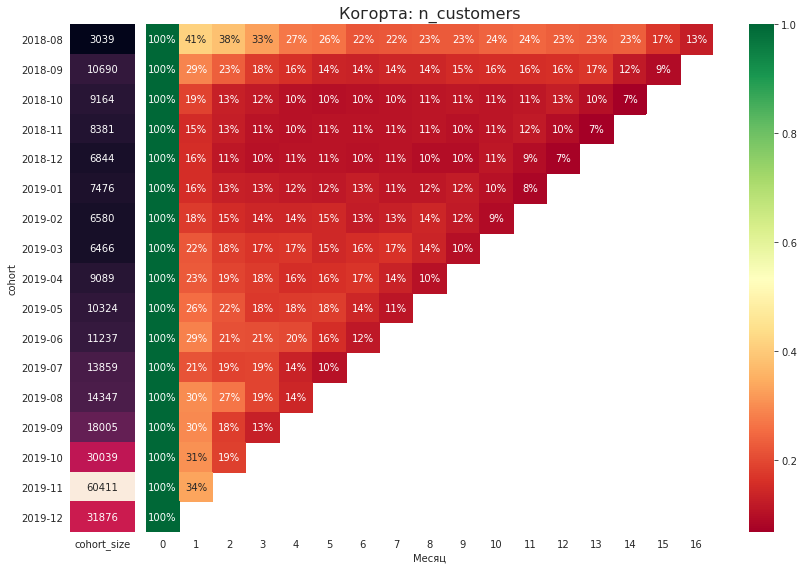

In [460]:
cohort_heatmap(cohort_df_transform, 'n_customers')

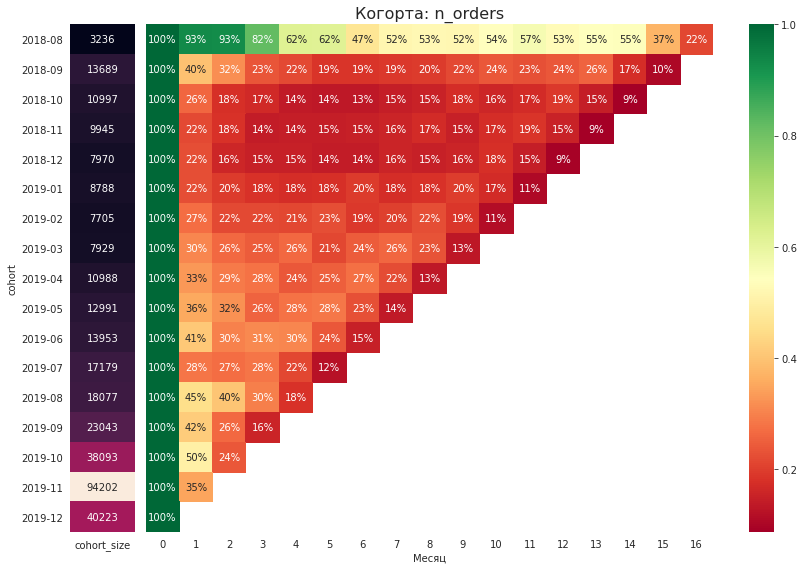

In [461]:
cohort_heatmap(cohort_df_transform, 'n_orders')

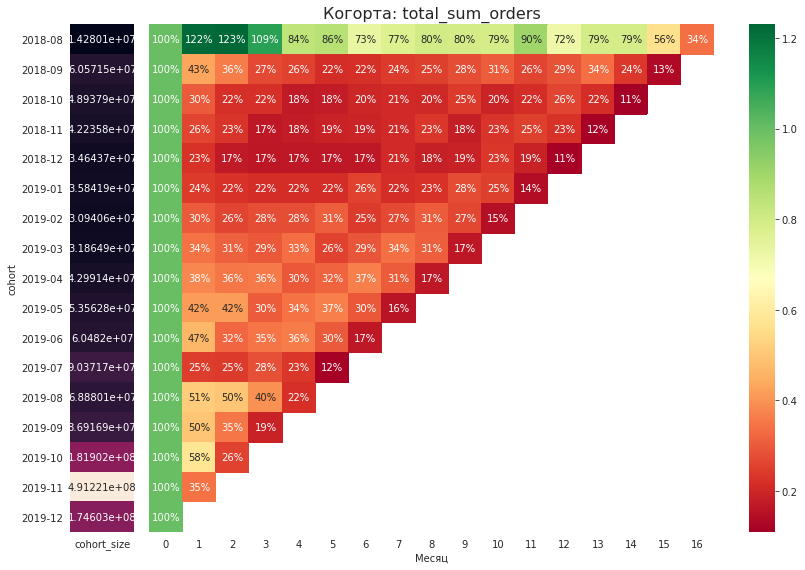

In [462]:
cohort_heatmap(cohort_df_transform, 'total_sum_orders')

In [ ]:
# Выводы

# RFM-анализ

In [67]:
orders_w_regions = reduce_mem_usage(orders_w_regions)

Mem. usage decreased to 81.15 Mb (4.8% reduction)


In [68]:
orders_w_regions.columns

Index(['id', 'user_id', 'total_cost', 'cost', 'item_total', 'promo_total',
       'total_weight', 'total_quantity', 'state', 'shipped_at', 'created_at',
       'ship_address_id', 'store_id', 'delivery_window_id', 'created_at_month',
       'created_at_dayofweek', 'created_at_year', 'shipped_at_month',
       'shipped_at_dayofweek', 'shipped_at_year', 'name'],
      dtype='object')

In [40]:
rfm_df = orders_w_regions.set_index('created_at').sort_values('created_at').drop_duplicates()

In [44]:
last_date = orders_w_regions['created_at'].max()
last_date

Timestamp('2019-12-18 18:02:41')

In [74]:
rfm_df = orders_w_regions.groupby('user_id').agg({'created_at': lambda x: (last_date - x.max()).days, # Дней с последнего заказа
                                               'id': lambda x: len(x), # Количество заказов
                                               'item_total': lambda x: x.sum()}) # Сумма по заказам

In [75]:
rfm_df['created_at'] = rfm_df['created_at'].astype('int16')

In [76]:
rfm_df.columns = ['recency', 'frequency', 'monetary_value']

In [81]:
# Проверим размерность
rfm_df.shape[0], orders['user_id'].nunique()

(257827, 257827)

In [84]:
# 1 класс - самые "хорошие пользователи", 2 -хуже и т.д.
quantile = rfm_df.quantile([0.25, 0.5, 0.75])
quantile

,recency,frequency,monetary_value
0.25,14.0,1.0,2988.0
0.50,48.0,1.0,5647.0
0.75,156.0,3.0,12975.0


In [85]:
def r_class(value, params, quant_table):
    if value <= quant_table[params][0.25]:
        return 1
    elif value <= quant_table[params][0.50]:
        return 2
    elif value <= quant_table[params][0.75]:
        return 3
    else:
        return 4
    

In [90]:
def fm_class(value, params, quant_table):
    if value <= quant_table[params][0.25]:
        return 4
    elif value <= quant_table[params][0.50]:
        return 3
    elif value <= quant_table[params][0.75]:
        return 2
    else:
        return 1

In [86]:
rfm_segmentation = rfm_df

In [93]:
rfm_segmentation['r_quartile'] = rfm_segmentation['recency'].apply(r_class, args=('recency', quantile))
rfm_segmentation['f_quartile'] = rfm_segmentation['frequency'].apply(fm_class, args=('frequency', quantile))
rfm_segmentation['m_quartile'] = rfm_segmentation['monetary_value'].apply(fm_class, args=('monetary_value', quantile))

In [95]:
# Пользователи с RFM индексом 444 самые "плохие", т.е они уже давно не совершали заказы, заказов было мало и по сумме они были не большие.
# Основная задача RFM анализа выявит таких пользователей и попытаться переместить их в другую группу, используя различные инструменты привлечения пользователя в сервис(промо-коды, скидка на конкретные товары, бесплатная доставка и т.д)

rfm_segmentation['RFM'] = rfm_segmentation['r_quartile'].map(str) \
                        + rfm_segmentation['f_quartile'].map(str) \
                        + rfm_segmentation['m_quartile'].map(str) 

In [96]:
rfm_segmentation

,recency,frequency,monetary_value,r_quantile,f_quantile,m_quantile,r_quartile,f_quartile,m_quartile,RFM
user_id,,,,,,,,,,
31,8,41,564043,1,1,1,1,1,1,111
45,6,31,94045,1,1,1,1,1,1,111
63,452,1,5789,4,4,2,4,4,2,442
167,329,37,338858,4,1,1,4,1,1,411
176,273,1,6704,4,4,2,4,4,2,442
...,...,...,...,...,...,...,...,...,...,...
1837005,0,1,1117,1,4,4,1,4,4,144
1837043,0,1,2318,1,4,4,1,4,4,144
1837423,0,1,1654,1,4,4,1,4,4,144


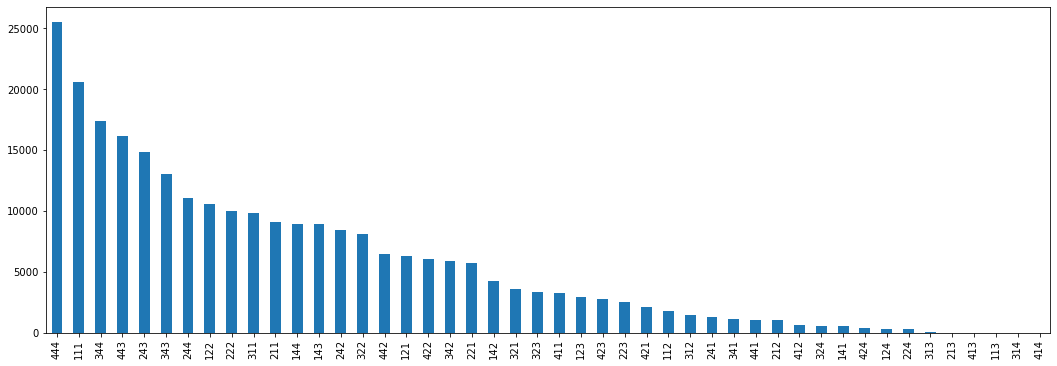

In [103]:
plt.rcParams['figure.figsize'] = (18, 6)
rfm_segmentation['RFM'].value_counts().sort_values(ascending=False).plot(kind='bar');

RFM = 111 — имеют высокий чек, часто покупают и совершали покупки недавно. Самые лояльным и активные пользователи.
RFM = 444 — имеют низкий чек, покупают нечасто и давно совершали покупки. Скорее всего потерянные клиенты. Возможно не стоит предпринять действия по их возврату, если цена привлечения выше ожидаемой прибыли.

R=4, F=1 - Новые покупатели R=4, F=4, M=3 - Лояльные покупатели

R=1-2, F=2-4, M=3-4 — лояльные пользователи на грани ухода. Стоит предложить им скидку, чтобы стимулировать совершить повторный заказ.
R=3-4, F=1, M=1-2-3-4 — пользователи недавно совершили платеж.

In [104]:
# RFM анализ по услугам доставки 
rfm_delivery= orders_w_regions.groupby('user_id').agg({'created_at': lambda x: (last_date - x.max()).days, # Дней с последнего заказа
                                               'id': lambda x: len(x), # Количество заказов
                                               'total_cost': lambda x: x.sum()}) # Сумма по доставкам

In [105]:
rfm_delivery

,created_at,id,total_cost
user_id,,,
31,8,41,10152.0
45,6,31,7384.0
63,452,1,249.0
167,329,37,9568.0
176,273,1,0.0
...,...,...,...
1837005,0,1,98.0
1837043,0,1,98.0
1837423,0,1,98.0


In [106]:
rfm_delivery['created_at'] = rfm_delivery['created_at'].astype('int16')

In [111]:
rfm_delivery.columns = ['recency', 'frequency', 'monetary_value']

In [112]:
# 1 класс - самые "хорошие пользователи", 2 -хуже и т.д.
quantile_delivery = rfm_delivery.quantile([0.25, 0.5, 0.75])
quantile_delivery

,recency,frequency,monetary_value
0.25,14.0,1.0,49.0
0.50,48.0,1.0,164.0
0.75,156.0,3.0,455.0


In [113]:
rfm_segmentation_delivery = rfm_delivery

In [114]:
rfm_segmentation_delivery['r_quartile'] = rfm_segmentation_delivery['recency'].apply(r_class, args=('recency', quantile))
rfm_segmentation_delivery['f_quartile'] = rfm_segmentation_delivery['frequency'].apply(fm_class, args=('frequency', quantile))
rfm_segmentation_delivery['m_quartile'] = rfm_segmentation_delivery['monetary_value'].apply(fm_class, args=('monetary_value', quantile))

In [ ]:
rfm_segmentation['RFM'] = rfm_segmentation['r_quartile'].map(str) \
                        + rfm_segmentation['f_quartile'].map(str) \
                        + rfm_segmentation['m_quartile'].map(str) 

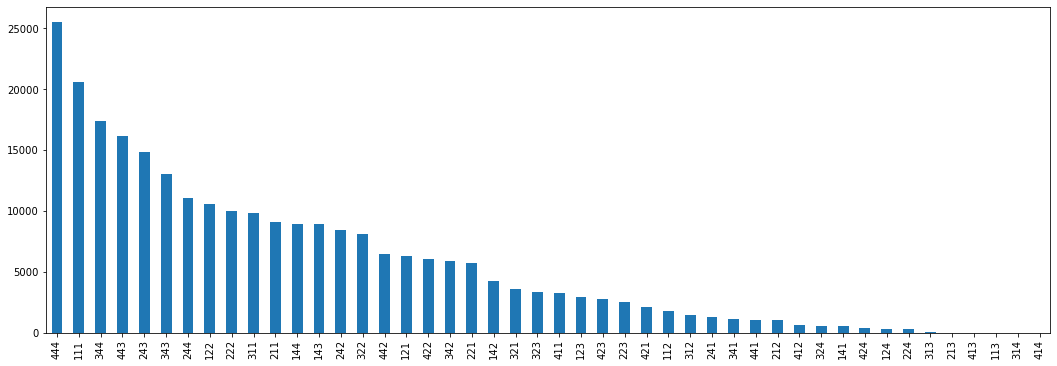

In [115]:
plt.rcParams['figure.figsize'] = (18, 6)
rfm_segmentation['RFM'].value_counts().sort_values(ascending=False).plot(kind='bar');